## Rainfall rates 

In [242]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib import dates
import math
import xarray
%matplotlib inline
import pyart
import glob
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors
from copy import deepcopy
from scipy import ndimage
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

50 54
-12.4287087678
130.887335488


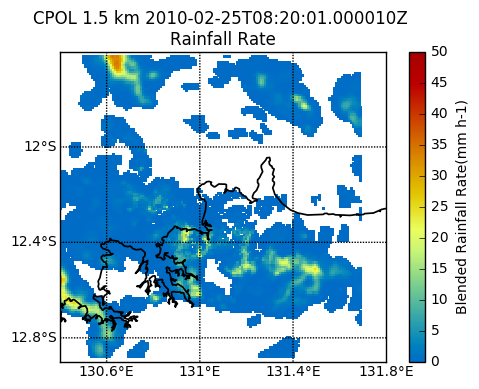

In [72]:
grid_path = '/home/rjackson/data/radar/gridded_data/CPOL_20100225_0820_GRIDS_1000m.nc'

grid = pyart.io.read_grid(grid_path)
display = pyart.graph.GridMapDisplay(grid)
display.plot_basemap(min_lat=-12.9, max_lat=-11.6,
                                 min_lon=130.4, max_lon=131.8,
                                 auto_range=False,
                                 lat_lines=[-12.8, -12.4, -12.0, -11.6],
                                 lon_lines=[130.6, 131.0, 131.4, 131.8],
                                 resolution='h')
display.plot_grid('radar_estimated_rain_rate', level=3, cmap='pyart_HomeyerRainbow')
rains = grid.fields['radar_estimated_rain_rate']['data']

dis_lat = -12.0 - 25/60.0 - 30/3600.0
dis_lon = 130.0 + 53.0/60.0 + 31.2/3600.0
lats = grid.point_latitude['data'][0,:,0]
lons = grid.point_longitude['data'][0,0,:]
lat_index_dis = (np.abs(lats-dis_lat)).argmin()
lon_index_dis = (np.abs(lons-dis_lon)).argmin()
print(lat_index_dis, lon_index_dis)
print(grid.point_latitude['data'][0,50,53])
print(grid.point_longitude['data'][0,50,53])

0.91539


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

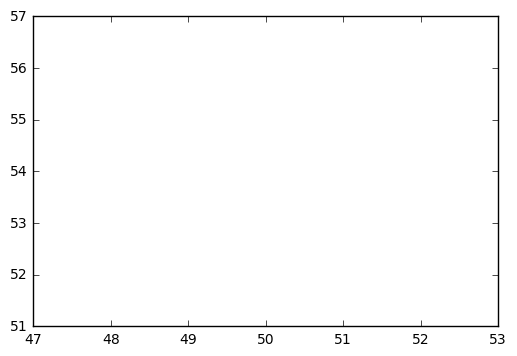

In [83]:
rains = grid.fields['radar_estimated_rain_rate']['data'][4,50,53]
print(rains)
#plt.pcolormesh(rains, vmin=0, vmax=90)
plt.plot(50,54, markersize=6)
plt.colorbar()

In [179]:
rainfall_rate_path = '/home/rjackson/data/rainfall_rate_timeseries*.cdf'
ds = xarray.open_mfdataset(rainfall_rate_path)
print(ds)

<xarray.Dataset>
Dimensions:                    (time: 120381)
Coordinates:
  * time                       (time) datetime64[ns] 2006-01-01 ...
Data variables:
    rainfall_cpol_over_impact  (time) float64 nan nan nan nan nan nan nan ...
    rainfall_cpol_over_vdis    (time) float64 nan nan nan nan nan nan nan ...
    rainfall_vdis              (time) float64 nan nan nan nan nan nan nan ...
    rainfall_disdro            (time) float64 nan nan nan nan nan nan nan ...
    graupel_present            (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    hail_present               (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    units:      mm hr-1
    long_name:  Rainfall rate algorithm based on Thompsonet al. 2016.


(734161.0423611111, 734222.0423611111)

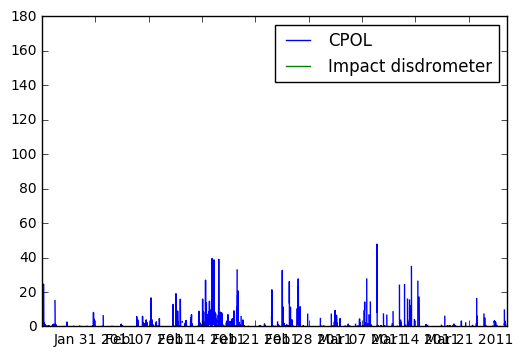

In [180]:
plt.plot(ds['time'].values, ds['rainfall_cpol_over_vdis'].values)
plt.plot(ds['time'].values, ds['rainfall_vdis'].values)
plt.legend(['CPOL', 'Impact disdrometer'])
plt.xlim([datetime.datetime(2011,1,24,1,1), datetime.datetime(2011,3,26,1,1)])

In [167]:
ds['rainfall_disdro'].sel(time=datetime.datetime(2011,2,26,1,0)).values

array(nan)

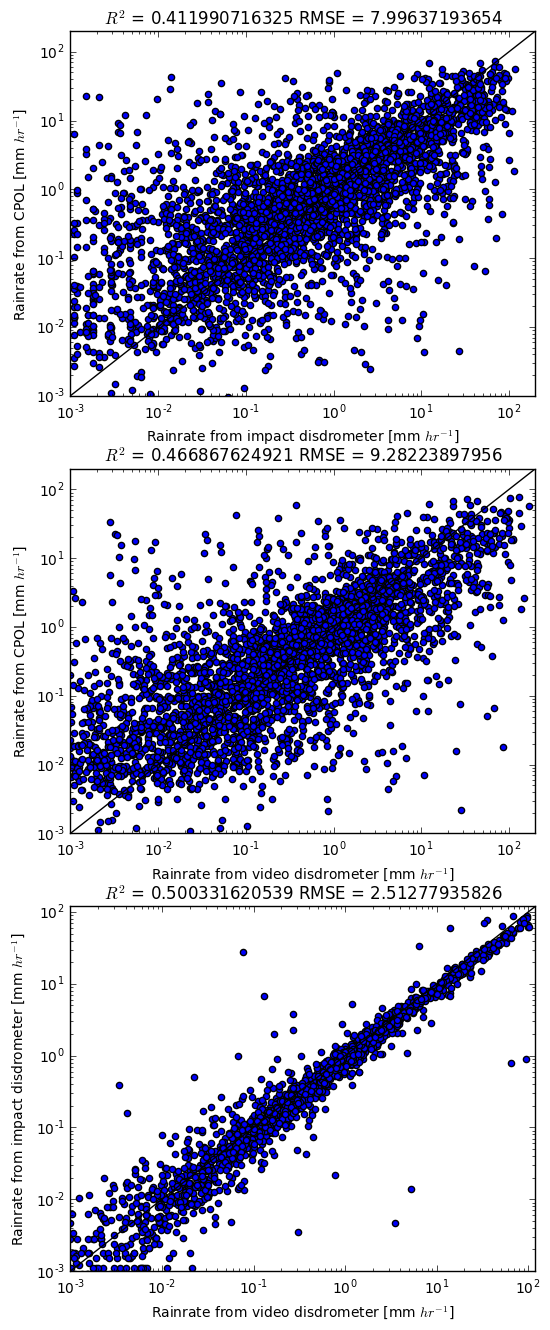

In [243]:
fig, ax = plt.subplots(3,1, figsize=(6,16))
ax[0].scatter(ds['rainfall_disdro'].values,
            ds['rainfall_cpol_over_vdis'].values)
isfinite = np.logical_and(ds['rainfall_disdro'].values > 0.0, 
                          ds['rainfall_cpol_over_vdis'].values > 0.0)
r2 = r2_score(np.log10(ds['rainfall_disdro'].values[isfinite]),
            np.log10(ds['rainfall_cpol_over_vdis'].values[isfinite]))
rmse = np.sqrt(mean_squared_error(np.log10(ds['rainfall_disdro'].values[isfinite]),
            np.log10(ds['rainfall_cpol_over_vdis'].values[isfinite])))
ax[0].set_xlabel('Rainrate from impact disdrometer [mm $hr^{-1}$]')
ax[0].set_ylabel('Rainrate from CPOL [mm $hr^{-1}$]')
ax[0].set_xlim([1e-3, 200])
ax[0].set_ylim([1e-3, 200])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].plot([0, 200], [0, 200], color='k')
ax[0].set_title('$R^2$ = ' + str(r2) + ' RMSE = ' + str(10**rmse))

ax[1].scatter(ds['rainfall_vdis'].values,
            ds['rainfall_cpol_over_vdis'].values)
isfinite = np.logical_and(ds['rainfall_vdis'].values > 0.0, 
                          ds['rainfall_cpol_over_vdis'].values > 0.0)
r2 = r2_score(np.log10(ds['rainfall_vdis'].values[isfinite]),
            np.log10(ds['rainfall_cpol_over_vdis'].values[isfinite]))
rmse = np.sqrt(mean_squared_error(np.log10(ds['rainfall_vdis'].values[isfinite]),
            np.log10(ds['rainfall_cpol_over_vdis'].values[isfinite])))
ax[1].set_xlabel('Rainrate from video disdrometer [mm $hr^{-1}$]')
ax[1].set_ylabel('Rainrate from CPOL [mm $hr^{-1}$]')
ax[1].set_xlim([1e-3, 200])
ax[1].set_ylim([1e-3, 200])
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].plot([0, 200], [0, 200], color='k')
ax[1].set_title('$R^2$ = ' + str(r2) + ' RMSE = ' + str(10**rmse))


ax[2].scatter(ds['rainfall_vdis'].values,
            ds['rainfall_disdro'].values)
isfinite = np.logical_and(ds['rainfall_vdis'].values < 1000.0, 
                          ds['rainfall_disdro'].values < 1000.0)
r2 = r2_score(ds['rainfall_vdis'].values[isfinite],
            ds['rainfall_disdro'].values[isfinite])
rmse = np.sqrt(mean_squared_error(ds['rainfall_disdro'].values[isfinite],
            ds['rainfall_vdis'].values[isfinite]))
ax[2].set_xlabel('Rainrate from video disdrometer [mm $hr^{-1}$]')
ax[2].set_ylabel('Rainrate from impact disdrometer [mm $hr^{-1}$]')
ax[2].set_xlim([1e-3, 120])
ax[2].set_ylim([1e-3, 120])
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].plot([0, 200], [0, 200], color='k')
ax[2].set_title('$R^2$ = ' + str(r2) + ' RMSE = ' + str(rmse))

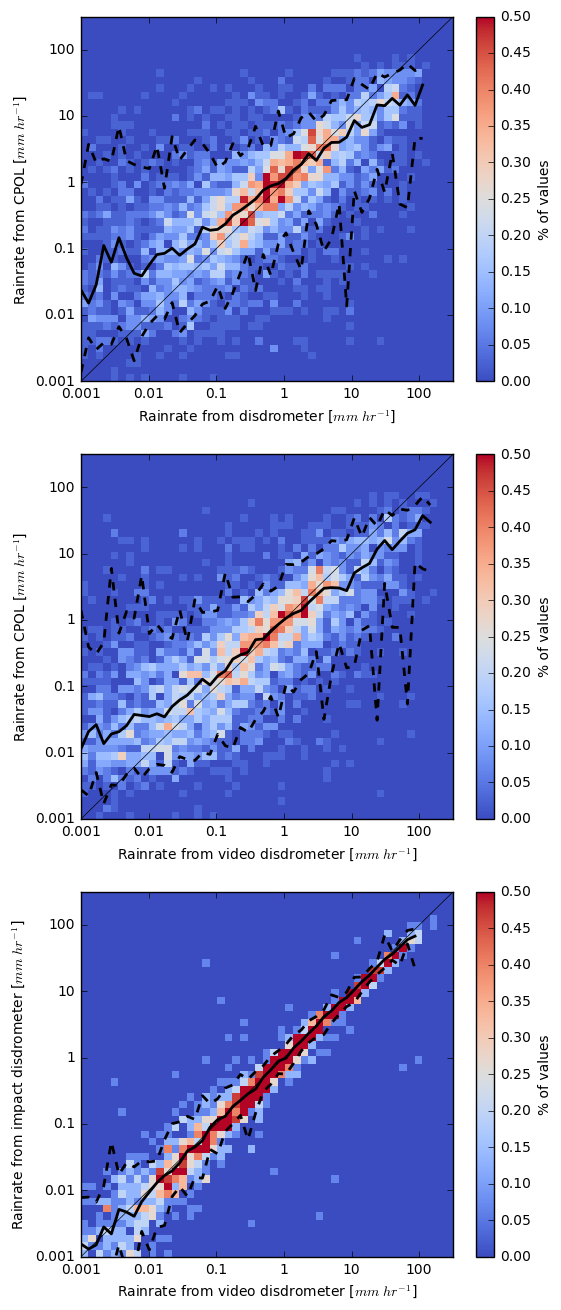

In [262]:
avg_bins=np.logspace(-3, 2.5, 50)
non_zero = np.logical_and.reduce((ds['rainfall_disdro'].values > 0, 
                                  ds['rainfall_cpol_over_vdis'].values > 0,))
hist, bins_x, bins_y = np.histogram2d(ds['rainfall_disdro'].values[non_zero],
                                      ds['rainfall_cpol_over_vdis'].values[non_zero],
                                      bins=avg_bins)
fig, ax = plt.subplots(3,1, figsize=(6,16))
c = ax[0].pcolormesh(np.log10(bins_x), np.log10(bins_y), hist.T/np.sum(hist)*100, vmin=0, vmax=0.5, cmap='coolwarm')
plt.colorbar(c, ax=ax[0], label='% of values')
ax[0].plot([-3, 2.5], [-3, 2.5], color='k', linewidth=0.5)
ax[0].set_xlim([-3, 2.5])
ax[0].set_ylim([-3, 2.5])
ax[0].set_yticks([-3, -2, -1, 0, 1, 2])
ax[0].set_xticks([-3, -2, -1, 0, 1, 2])
ax[0].set_yticklabels(['0.001', '0.01', '0.1', '1', '10', '100'])
ax[0].set_xticklabels(['0.001', '0.01', '0.1', '1', '10', '100'])
ax[0].set_xlabel('Rainrate from disdrometer [$mm\ hr^{-1}$]')
ax[0].set_ylabel('Rainrate from CPOL [$mm\ hr^{-1}$]')

quartiles_x = np.zeros((len(avg_bins)-1,3))
quartiles_y = np.zeros((len(avg_bins)-1,3))
array1 = ds['rainfall_disdro'].values[non_zero]
array2 = ds['rainfall_cpol_over_vdis'].values[non_zero]
for i in range(0, len(avg_bins)-1):
    x_restrictions = np.logical_and(array1 >= avg_bins[i],
                                    array1 < avg_bins[i+1])
    y_restrictions = np.logical_and(array2 >= avg_bins[i],
                                    array2 < avg_bins[i+1])
    quartiles_y[i,:] = np.nanpercentile(array2[x_restrictions],
                                        [5, 50, 95])
    quartiles_x[i,:] = np.nanpercentile(array1[y_restrictions],
                                        [5, 50, 95])

ax[0].plot(np.log10(avg_bins[:-1]), np.log10(quartiles_y[:,1]), color='k', linewidth=2)
ax[0].plot(np.log10(avg_bins[:-1]), np.log10(quartiles_y[:,2]), color='k', linestyle='--', linewidth=2)
ax[0].plot(np.log10(avg_bins[:-1]), np.log10(quartiles_y[:,0]), color='k', linestyle='--', linewidth=2)             


non_zero = np.logical_and(ds['rainfall_vdis'].values > 0, ds['rainfall_cpol_over_vdis'].values > 0)
hist, bins_x, bins_y = np.histogram2d(ds['rainfall_vdis'].values[non_zero],
                                      ds['rainfall_cpol_over_vdis'].values[non_zero],
                                      bins=avg_bins)
c = ax[1].pcolormesh(np.log10(bins_x), np.log10(bins_y), hist.T/np.sum(hist)*100, vmin=0, vmax=0.5, cmap='coolwarm')
plt.colorbar(c, ax=ax[1], label='% of values')
ax[1].plot([-3, 2.5], [-3, 2.5], color='k', linewidth=0.5)
ax[1].set_xlim([-3, 2.5])
ax[1].set_ylim([-3, 2.5])
ax[1].set_yticks([-3, -2, -1, 0, 1, 2])
ax[1].set_xticks([-3, -2, -1, 0, 1, 2])
ax[1].set_yticklabels(['0.001', '0.01', '0.1', '1', '10', '100'])
ax[1].set_xticklabels(['0.001', '0.01', '0.1', '1', '10', '100'])
ax[1].set_xlabel('Rainrate from video disdrometer [$mm\ hr^{-1}$]')
ax[1].set_ylabel('Rainrate from CPOL [$mm\ hr^{-1}$]')

quartiles_x = np.zeros((len(avg_bins)-1,3))
quartiles_y = np.zeros((len(avg_bins)-1,3))
array1 = ds['rainfall_vdis'].values[non_zero]
array2 = ds['rainfall_cpol_over_vdis'].values[non_zero]
for i in range(0, len(avg_bins)-1):
    x_restrictions = np.logical_and(array1 >= avg_bins[i],
                                    array1 < avg_bins[i+1])
    y_restrictions = np.logical_and(array2 >= avg_bins[i],
                                    array2 < avg_bins[i+1])
    quartiles_y[i,:] = np.nanpercentile(array2[x_restrictions],
                                        [5, 50, 95])
    quartiles_x[i,:] = np.nanpercentile(array1[y_restrictions],
                                        [5, 50, 95])

ax[1].plot(np.log10(avg_bins[:-1]), np.log10(quartiles_y[:,1]), color='k', linewidth=2)
ax[1].plot(np.log10(avg_bins[:-1]), np.log10(quartiles_y[:,2]), color='k', linestyle='--', linewidth=2)
ax[1].plot(np.log10(avg_bins[:-1]), np.log10(quartiles_y[:,0]), color='k', linestyle='--', linewidth=2)             

non_zero = np.logical_and(ds['rainfall_vdis'].values > 0, ds['rainfall_disdro'].values > 0)
hist, bins_x, bins_y = np.histogram2d(ds['rainfall_vdis'].values[non_zero],
                                      ds['rainfall_disdro'].values[non_zero],
                                      bins=avg_bins)
c = ax[2].pcolormesh(np.log10(bins_x), np.log10(bins_y), hist.T/np.sum(hist)*100, vmin=0, vmax=0.5, cmap='coolwarm')
plt.colorbar(c, ax=ax[2], label='% of values')
ax[2].plot([-3, 2.5], [-3, 2.5], color='k', linewidth=0.5)
ax[2].set_xlim([-3, 2.5])
ax[2].set_ylim([-3, 2.5])
ax[2].set_yticks([-3, -2, -1, 0, 1, 2])
ax[2].set_xticks([-3, -2, -1, 0, 1, 2])
ax[2].set_yticklabels(['0.001', '0.01', '0.1', '1', '10', '100'])
ax[2].set_xticklabels(['0.001', '0.01', '0.1', '1', '10', '100'])
ax[2].set_xlabel('Rainrate from video disdrometer [$mm\ hr^{-1}$]')
ax[2].set_ylabel('Rainrate from impact disdrometer [$mm\ hr^{-1}$]')

quartiles_x = np.zeros((len(avg_bins)-1,3))
quartiles_y = np.zeros((len(avg_bins)-1,3))
array1 = ds['rainfall_vdis'].values[non_zero]
array2 = ds['rainfall_disdro'].values[non_zero]
for i in range(0, len(avg_bins)-1):
    x_restrictions = np.logical_and(array1 >= avg_bins[i],
                                    array1 < avg_bins[i+1])
    y_restrictions = np.logical_and(array2 >= avg_bins[i],
                                    array2 < avg_bins[i+1])
    quartiles_y[i,:] = np.nanpercentile(array2[x_restrictions],
                                        [5, 50, 95])
    quartiles_x[i,:] = np.nanpercentile(array1[y_restrictions],
                                        [5, 50, 95])

ax[2].plot(np.log10(avg_bins[:-1]), np.log10(quartiles_y[:,1]), color='k', linewidth=2)
ax[2].plot(np.log10(avg_bins[:-1]), np.log10(quartiles_y[:,2]), color='k', linestyle='--', linewidth=2)
ax[2].plot(np.log10(avg_bins[:-1]), np.log10(quartiles_y[:,0]), color='k', linestyle='--', linewidth=2) 

In [3]:
rainfall_rate_path = '/home/rjackson/data/rainfall_rates_disdrometer_2locs.cdf'
rainfall_dist_path = '/home/rjackson/data/rainfall_rates_disdrometer.cdf'

file_path = '/home/rjackson/data/Drosdowsky.cdf'

in_netcdf = Dataset(file_path)
year = in_netcdf.variables['year'][:]
month = in_netcdf.variables['month'][:]
day = in_netcdf.variables['day'][:]
groups = in_netcdf.variables['groups'][:]
cape = in_netcdf.variables['cape'][:]
shear = in_netcdf.variables['shear'][:]
rh500 = in_netcdf.variables['rh500'][:]

times_dros = []
for i in range(0, len(year)):
    cur_time = datetime.datetime(year=int(year[i]),
                                 month=int(month[i]),
                                 day=int(day[i]))
    times_dros.append(cur_time)

In [144]:
rainfall_data = Dataset(rainfall_dist_path, mode='r')

In [193]:
the_years_mjo = np.array([x.year for x in the_dates_mjo])
the_months_mjo = np.array([x.month for x in the_dates_mjo])
year_inds = np.logical_and(the_years_mjo >= 1998, the_years_mjo <= 2015)
month_inds = np.logical_or(the_months_mjo < 5, the_months_mjo > 10)
mjos_in_season = mjo[np.logical_and(year_inds, month_inds)]
days_in_mjo, mjo_nums = np.histogram(mjos_in_season, range(1,10))
print(days_in_mjo)

[260 360 453 451 464 503 435 336]


In [272]:
def percentile_from_histogram(hist, bins, percentile):
    cumsum = np.cumsum(hist)/np.sum(hist)*100
    the_index = np.where(cumsum < percentile)[0]
    if(len(the_index) < 1):
        return np.nan
    else:
        the_index = the_index[-1]
        
    if(the_index < len(bins)-1):
        width = cumsum[the_index+1]-cumsum[the_index]
    else:
        width = 100 - cumsum[the_index]
    distance = (percentile-cumsum[the_index])/width
    return bins[the_index]*(1+distance*(bins[the_index+1]-bins[the_index]))

[10, 20, 30, 40, 50, 60, 70, 80]


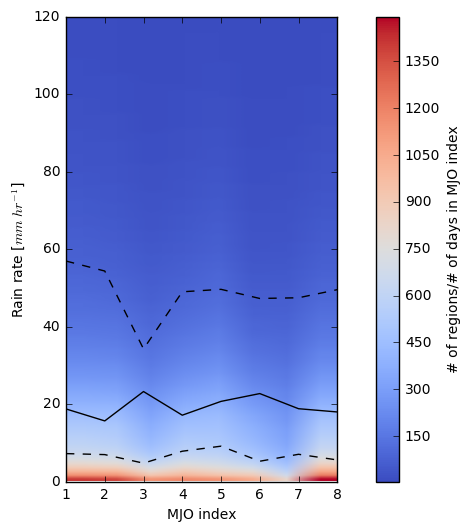

In [280]:
mjo_hist = np.zeros((8, len(bins)))
medians = np.zeros(8)
ninety = np.zeros(8)
five = np.zeros(8)

for mjo_index in range(1,9):
    mjo_hist[mjo_index-1,:] = np.sum(rainfall_hists[np.where(np.logical_and(mjo_ind[:] == mjo_index,
                                                                            dros_class == 0)),:], axis=1)
    mjo_hist[mjo_index-1,:] = mjo_hist[mjo_index-1,:]/days_in_mjo[mjo_index-1]
    medians[mjo_index-1] = percentile_from_histogram(mjo_hist[mjo_index-1], bins, 50)
    ninety[mjo_index-1] = percentile_from_histogram(mjo_hist[mjo_index-1], bins, 75)
    five[mjo_index-1] = percentile_from_histogram(mjo_hist[mjo_index-1], bins, 25)
    
fig = plt.figure(figsize=(10,6))
ax = plt.axes
plt.imshow(np.transpose(mjo_hist[:,-1:0:-1]), extent=[10,80,0,125], cmap='coolwarm')
print(range(10,90,10))
plt.plot(range(10,90,10), ninety, linestyle='--', color='k')
plt.plot(range(10,90,10), five, linestyle='--', color='k')
plt.plot(range(10,90,10), medians, color='k')
plt.ylabel('Rain rate [$mm\ hr^{-1}$]')
plt.xlabel('MJO index')
plt.xticks(np.arange(10,100, 10), ['1','2','3','4','5','6','7','8'])
plt.ylim([0, 120])
plt.xlim([10,80])
ax = plt.colorbar()
ax.set_label('# of regions/# of days in MJO index')

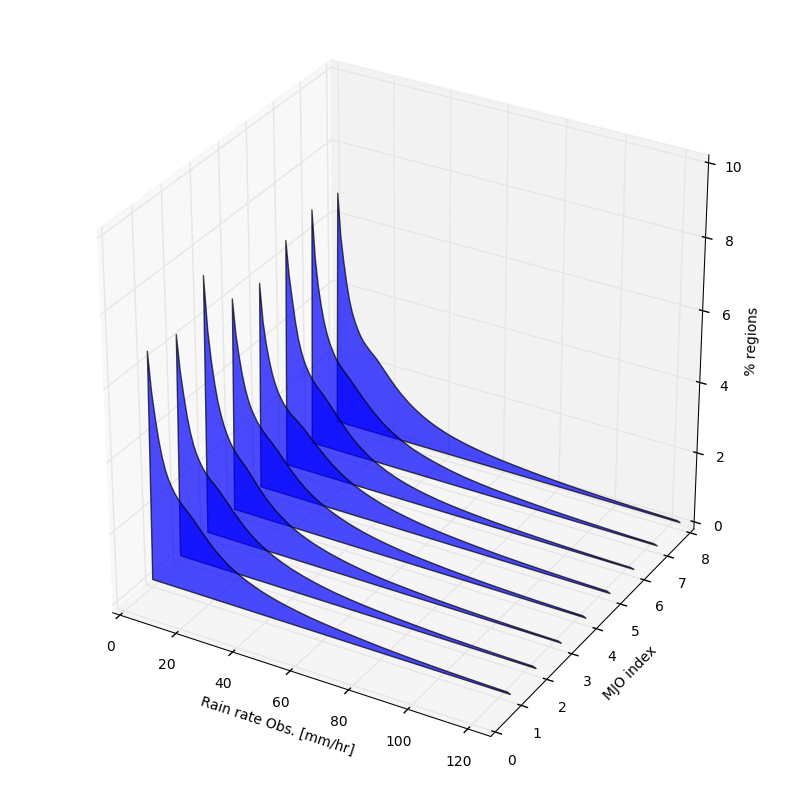

In [162]:
from matplotlib import colors as mcolors
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = bins
verts = []
zs = np.arange(1, 9, 1.0)
i = 0
for z in zs:
    ys = mjo_hist[i]/np.sum(mjo_hist[i])*100
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))
    i = i + 1

poly = PolyCollection(verts)
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_xlabel('Rain rate Obs. [mm/hr]')
ax.set_xlim3d(0, 125)
ax.set_ylabel('MJO index')
ax.set_ylim3d(0, 8)
ax.set_zlabel('% regions')
ax.set_zlim3d(0, 10)

plt.show()